In [ ]:
import time
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 先买了一个9刀的API Basic plan
leonardo_api_key = "9a661d58-49a6-499b-bb3c-8449d8f29262"
authorization = "Bearer %s" % leonardo_api_key

In [ ]:
# Helper Function: make output json response more readable
def formatJsonResponse(response):
  response_dict = json.loads(response.text) # 将json字符串转换为字典
  formatted_response = json.dumps(response_dict, indent=4) # 使用 json.dumps() 格式化输出
  return formatted_response

In [ ]:
# Test API key
url = "https://cloud.leonardo.ai/api/rest/v1/me"
headers = {
    "accept": "application/json",
    "authorization": authorization
}
response = requests.get(url, headers=headers)
formatted_response = formatJsonResponse(response)
print(formatted_response)

{
    "user_details": [
        {
            "user": {
                "id": "dbc27344-e93d-4c40-8d98-9604ac8fbc78",
                "username": "racheltanhao"
            },
            "tokenRenewalDate": null,
            "paidTokens": 0,
            "subscriptionTokens": 150,
            "subscriptionGptTokens": 100,
            "subscriptionModelTokens": 0,
            "apiConcurrencySlots": 10,
            "apiPaidTokens": null,
            "apiSubscriptionTokens": 466,
            "apiPlanTokenRenewalDate": "2024-11-17T18:44:02.923794"
        }
    ]
}


In [ ]:
# Helper Function: make output json response more readable
def formatJson(response):
  response_dict = json.loads(response.text) # 将json字符串转换为字典
  formatted_response = json.dumps(response_dict, indent=4) # 使用 json.dumps() 格式化输出
  return formatted_response

In [ ]:
# Function: Generate an Image
def generate(prompt, num_images):
    url = "https://cloud.leonardo.ai/api/rest/v1/generations"

    payload = {
        "alchemy": True,
        "height": 768,
        "modelId": "b24e16ff-06e3-43eb-8d33-4416c2d75876",
        "num_images": num_images,
        "presetStyle": "DYNAMIC",
        "prompt": prompt,
        "width": 1024
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": authorization
    }

    # Send POST request to generate images
    response = requests.post(url, json=payload, headers=headers)
    print(response.text)  # Check the response for debugging

    # Convert response to dictionary
    response_dict = json.loads(response.text)

    # Extract generationId
    generation_id = response_dict.get("sdGenerationJob", {}).get("generationId")

    return generation_id



In [ ]:
# Function to retrieve generated image IDs without displaying them
def get_generated_image_ids(generation_id):
    url = f"https://cloud.leonardo.ai/api/rest/v1/generations/{generation_id}"

    headers = {
        "accept": "application/json",
        "authorization": authorization  # Ensure the authorization token is valid
    }

    # Fetch the generated images
    response = requests.get(url, headers=headers)
    response_dict = response.json()

    # Get the generated image IDs
    generated_images = response_dict.get('generations_by_pk', {}).get('generated_images', [])
    image_ids = []

    for image_data in generated_images:
        image_id = image_data['id']
        image_ids.append(image_id)

    return image_ids  # Return all image IDs

In [ ]:
# Function: Display Images
def display_images(generation_id):
    url = f"https://cloud.leonardo.ai/api/rest/v1/generations/{generation_id}"

    headers = {
        "accept": "application/json",
        "authorization": authorization
    }

    # Poll for image generation completion
    while True:
        response = requests.get(url, headers=headers)
        response_dict = json.loads(response.text)

        status = response_dict.get('generations_by_pk', {}).get('status', '')
        if status == "COMPLETE":
            break
        elif status == "FAILED":
            print(f"Image generation failed for ID: {generation_id}")
            return
        time.sleep(5)  # Wait before checking again

    # Get generated images and display them
    generated_images = response_dict.get('generations_by_pk', {}).get('generated_images', [])
    for i, image_data in enumerate(generated_images):
        image_url = image_data['url']
        image_id = image_data['id']
        print(f"Image {i+1}, id={image_id}, URL: {image_url}")

        # Fetch and display the image
        image_response = requests.get(image_url)
        img = Image.open(BytesIO(image_response.content))

        # Display image using matplotlib
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()

In [ ]:
# Function: Generate an image based on an image
def generate_with_image_id(image_id, prompt, num_images):

    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": authorization
    }

    # Generate with an image prompt: use Character Reference to control consistency
    url = "https://cloud.leonardo.ai/api/rest/v1/generations"

    payload = {
        "alchemy": True,
        "height": 768,
        "modelId": "b24e16ff-06e3-43eb-8d33-4416c2d75876",
        "num_images": num_images,
        "presetStyle": "DYNAMIC",
        "prompt": prompt,
        "width": 1024,
        "controlnets": [
              {
                  "initImageId": image_id,
                  "initImageType": "GENERATED",
                  "preprocessorId": 67, #Style Reference Id
                  "strengthType": "High",
              }
          ]
    }

    response = requests.post(url, json=payload, headers=headers)

    # Print response for debugging
    print(f"Status code: {response.status_code}")
    print(f"Response: {response.text}")

    # Get the generation of images
    generation_id = response.json()['sdGenerationJob']['generationId']
    return generation_id

In [ ]:
# Function to check the status of the generation until it is complete
def wait_for_image_generation(generation_id):
    url = f"https://cloud.leonardo.ai/api/rest/v1/generations/{generation_id}"
    headers = {
        "accept": "application/json",
        "authorization": authorization
    }

    # Poll the status every 5 seconds
    while True:
        response = requests.get(url, headers=headers)
        response_dict = response.json()
        status = response_dict.get('generations_by_pk', {}).get('status', 'PENDING')

        print(f"Current status for generation {generation_id}: {status}")

        if status == "COMPLETE":
            return response_dict
        elif status == "FAILED":
            print(f"Generation {generation_id} failed.")
            return None

        time.sleep(5)  # Wait before checking the status again

In [ ]:
# Function to upload a generated image into a dataset
def upload_image_to_dataset(dataset_id, generated_image_id):
    # Define the URL, dynamically inserting the dataset_id
    url = f"https://cloud.leonardo.ai/api/rest/v1/datasets/{dataset_id}/upload/gen"

    # Define the payload with the generated image ID
    payload = {
        "generatedImageId": generated_image_id
    }

    # Define the headers, make sure to include authorization if required
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": authorization  # Ensure the authorization token is valid
    }

    # Make the POST request to upload the image
    response = requests.post(url, json=payload, headers=headers)

    # Print and return the response (as a dictionary)
    print(response.text)  # For debugging
    return response.json()

In [ ]:
"""
Function to get the number of images in a dataset.
"""
def get_number_of_images_in_dataset(dataset_id):

    # Define the URL, dynamically inserting the dataset_id
    url = f"https://cloud.leonardo.ai/api/rest/v1/datasets/{dataset_id}"

    # Define the headers, make sure to include authorization if required
    headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": authorization
    }

    # Make the GET request to retrieve the dataset
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        response_data = response.json()
        dataset = response_data.get('datasets_by_pk')

        if dataset and dataset.get('dataset_images'):
            # Count the number of images in the 'dataset_images' array
            number_of_images = len(dataset['dataset_images'])
            print(f"Number of images in the dataset: {number_of_images}")
            return number_of_images
        else:
            print("No images found in the dataset.")
            return 0
    else:
        print(f"Failed to retrieve dataset. Status code: {response.status_code}")
        return 0

# Example usage:
dataset_id = "your-dataset-id"

# Call the function
num_images = get_number_of_images_in_dataset(dataset_id)

# Print the number of images
print(f"Total images in dataset {dataset_id}: {num_images}")


Failed to retrieve dataset. Status code: 400
Total images in dataset your-dataset-id: 0


In [ ]:
# Function to display all images in a dataset
def display_all_images_in_dataset(dataset_id):
    # Define the URL to fetch the dataset by ID
    url = f"https://cloud.leonardo.ai/api/rest/v1/datasets/{dataset_id}"

    headers = {
        "accept": "application/json",
        "authorization": authorization  # Ensure the authorization token is valid
    }

    # Fetch the dataset details, including images
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        dataset_info = response.json().get('datasets_by_pk', {})

        # Get the images from the dataset
        dataset_images = dataset_info.get('dataset_images', [])

        if not dataset_images:
            print(f"No images found in dataset {dataset_id}.")
            return

        print(f"Displaying {len(dataset_images)} images from dataset {dataset_id}:")

        # Iterate over each image in the dataset
        for i, image_data in enumerate(dataset_images):
            image_url = image_data['url']
            image_id = image_data['id']
            print(f"Image {i+1}, id={image_id}, URL: {image_url}")

            # Fetch and display the image
            image_response = requests.get(image_url)
            img = Image.open(BytesIO(image_response.content))

            # Display image using matplotlib
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.show()
    else:
        print(f"Failed to retrieve dataset {dataset_id}. Status code: {response.status_code}")
        print(response.text)

In [ ]:
describe_user = "8-year-old Asian girl with black hair, pigtail hairstyle, very pretty, cute"
prompt = "Highly detailed 3D Disney Pixar-style animation of a %s. Disney, Pixar art style, CGI, clean background, high details, 3d animation."  % describe_user
user_avatar_generation_id = generate(prompt, 4)

{"sdGenerationJob":{"generationId":"d0caf7be-dd0f-4800-b916-69a389a49abd","apiCreditCost":30}}


Image 1, id=80611ab8-61a7-4661-b745-699dfa95c4d6, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/generations/d0caf7be-dd0f-4800-b916-69a389a49abd/Leonardo_Lightning_XL_Highly_detailed_3D_Disney_Pixarstyle_ani_0.jpg


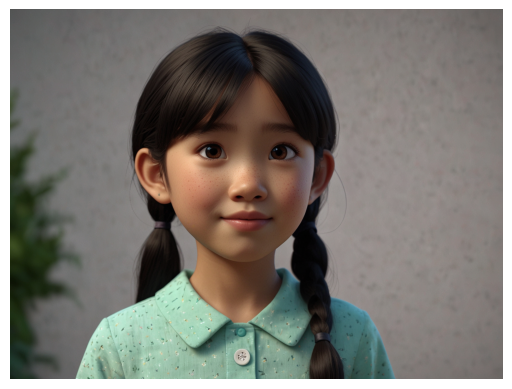

Image 2, id=70b3c9df-bffb-417e-bb36-1738432c54cc, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/generations/d0caf7be-dd0f-4800-b916-69a389a49abd/Leonardo_Lightning_XL_Highly_detailed_3D_Disney_Pixarstyle_ani_1.jpg


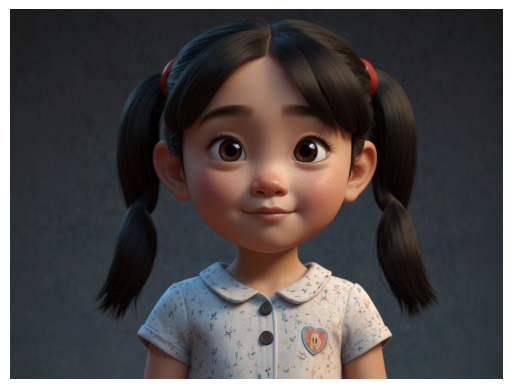

Image 3, id=bee43690-be95-4e88-8b8b-b3c0e21e268a, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/generations/d0caf7be-dd0f-4800-b916-69a389a49abd/Leonardo_Lightning_XL_Highly_detailed_3D_Disney_Pixarstyle_ani_2.jpg


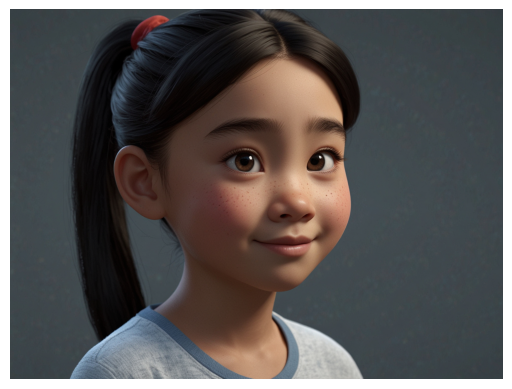

Image 4, id=bf8a069a-a2c9-4c5c-b3c1-db1c079fc343, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/generations/d0caf7be-dd0f-4800-b916-69a389a49abd/Leonardo_Lightning_XL_Highly_detailed_3D_Disney_Pixarstyle_ani_3.jpg


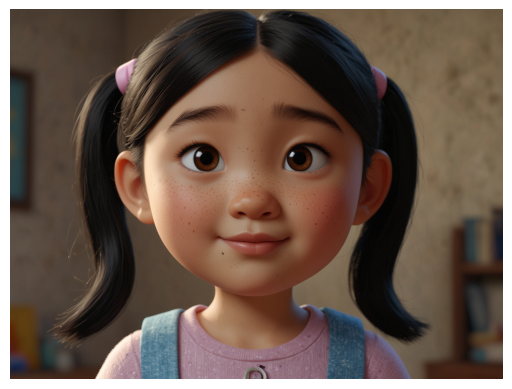

In [ ]:
display_images(user_avatar_generation_id)


In [ ]:
# Function to create a dataset for the user based on user selected avatar picture
def create_user_dataset(dataset_name, seed_image_id, describe_user):

  dataset_id = create_dataset(dataset_name)

  # default activities
  activities = [
    "playing basketball", "riding a bicycle", "reading a book",
    "playing the piano", "cooking in the kitchen", "flying a kite",
    "playing tennis", "swimming in a pool", "watering flowers"
  ]

  # Create and upload images for each activity
  for activity in activities:
      prompt = f"Highly detailed 3D Disney Pixar-style animation of a {describe_user}, {activity}. Disney, Pixar art style, CGI, high details, 3d animation."
      print(f"Generating image for activity: {activity}")

      # Generate image ID for the current activity
      generation_id = generate_with_image_id(seed_image_id, prompt, 1)

      if generation_id:
          generation_response = wait_for_image_generation(generation_id)

          if generation_response:
              image_ids = get_generated_image_ids(generation_id)

              for image_id in image_ids:
                  upload_image_to_dataset(dataset_id, image_id)

              num_images = get_number_of_images_in_dataset(dataset_id)
              print(f"Total images in dataset {dataset_id}: {num_images}")
          else:
              print(f"Failed to generate image for activity: {activity}")
      else:
          print(f"Failed to generate image for activity: {activity}")

  return dataset_id


# Function to create a dataset for storing training images
def create_dataset(name):
    url = "https://cloud.leonardo.ai/api/rest/v1/datasets"

    # Define headers (authorization, etc.)
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": authorization
    }

    # Define the payload with the dataset name
    payload = {
        "name": name
    }

    # Make the POST request to create a dataset
    response = requests.post(url, json=payload, headers=headers)
    # print("Dataset creation response:", response.json()) # Print the response for debugging

    # Check if the request was successful and extract the dataset ID
    if response.status_code == 200 and 'insert_datasets_one' in response.json():
        dataset_id = response.json()['insert_datasets_one']['id']
        print("Dataset has been created, its ID is:", dataset_id)
        return dataset_id
    else:
        print(f"Failed to create dataset. Status code: {response.status_code}")
        return None

In [ ]:
dataset_id = create_user_dataset("test_user_dataset", "70b3c9df-bffb-417e-bb36-1738432c54cc", describe_user)

Dataset creation response: {'insert_datasets_one': {'id': '7ecca318-abc7-405b-903e-484bc492ad44'}}
Dataset has been created, its ID is: 7ecca318-abc7-405b-903e-484bc492ad44
Generating image for activity: playing basketball
Status code: 200
Response: {"sdGenerationJob":{"generationId":"5b3b489f-be9c-4141-b0e5-ef85169bee32","apiCreditCost":16}}
Current status for generation 5b3b489f-be9c-4141-b0e5-ef85169bee32: PENDING
Current status for generation 5b3b489f-be9c-4141-b0e5-ef85169bee32: PENDING
Current status for generation 5b3b489f-be9c-4141-b0e5-ef85169bee32: PENDING
Current status for generation 5b3b489f-be9c-4141-b0e5-ef85169bee32: COMPLETE
{"uploadDatasetImageFromGen":{"id":"e6f921b7-dfab-45aa-9da1-eeb60f36e98e"}}
Number of images in the dataset: 1
Total images in dataset 7ecca318-abc7-405b-903e-484bc492ad44: 1
Generating image for activity: riding a bicycle
Status code: 200
Response: {"sdGenerationJob":{"generationId":"f4595d20-3dbd-4fa1-85a9-d1394b142b60","apiCreditCost":16}}
Curre

7ecca318-abc7-405b-903e-484bc492ad44
Number of images in the dataset: 9
Total images in dataset 7ecca318-abc7-405b-903e-484bc492ad44: 9
Displaying 9 images from dataset 7ecca318-abc7-405b-903e-484bc492ad44:
Image 1, id=e6f921b7-dfab-45aa-9da1-eeb60f36e98e, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/e6f921b7-dfab-45aa-9da1-eeb60f36e98e/primary.jpg


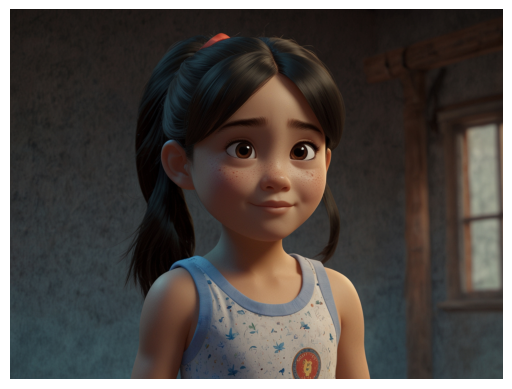

Image 2, id=02e5e73d-5d2a-4fb9-9f59-2c92800d1a15, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/02e5e73d-5d2a-4fb9-9f59-2c92800d1a15/primary.jpg


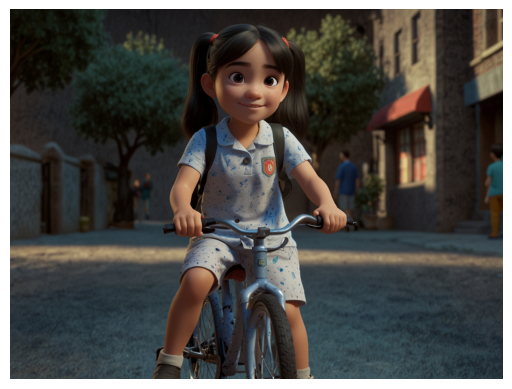

Image 3, id=ba18984c-e8eb-42f9-a895-fc6aaf654f36, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/ba18984c-e8eb-42f9-a895-fc6aaf654f36/primary.jpg


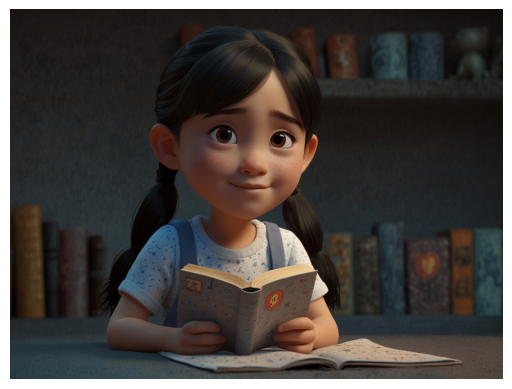

Image 4, id=29376d18-3c5b-4e6a-afff-6fd70a50d1ff, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/29376d18-3c5b-4e6a-afff-6fd70a50d1ff/primary.jpg


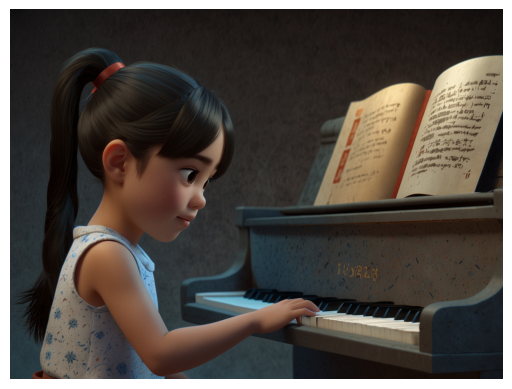

Image 5, id=7f43d9fe-f4dd-4fc4-9c11-31b9d417d5cc, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/7f43d9fe-f4dd-4fc4-9c11-31b9d417d5cc/primary.jpg


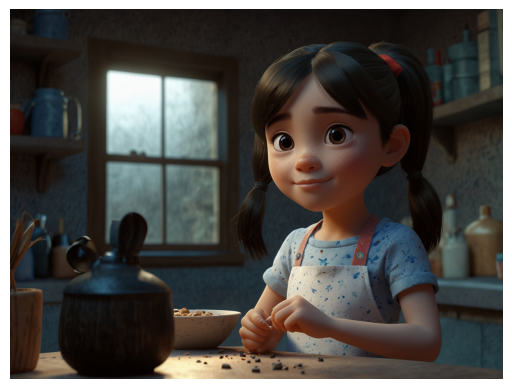

Image 6, id=d0a72c9e-e65f-4268-87c9-d221fb65e1db, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/d0a72c9e-e65f-4268-87c9-d221fb65e1db/primary.jpg


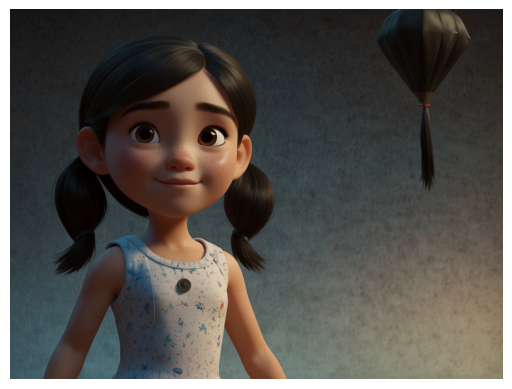

Image 7, id=8b9a1b0d-5625-49df-9e6f-e21070fdfde9, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/8b9a1b0d-5625-49df-9e6f-e21070fdfde9/primary.jpg


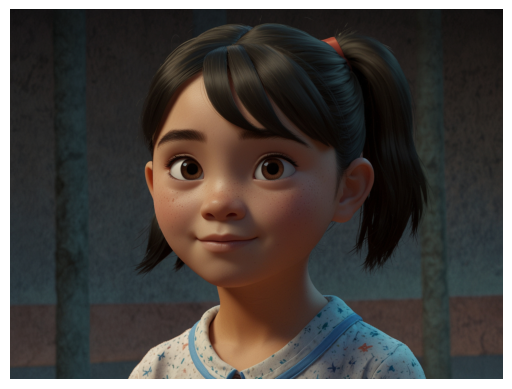

Image 8, id=d71d2db6-f9fa-462f-902c-f7ccb0344f59, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/d71d2db6-f9fa-462f-902c-f7ccb0344f59/primary.jpg


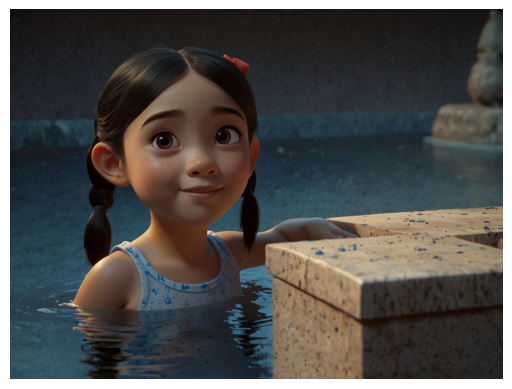

Image 9, id=9c2970a9-1902-443c-809f-22df90c8bc9a, URL: https://cdn.leonardo.ai/users/dbc27344-e93d-4c40-8d98-9604ac8fbc78/datasets/7ecca318-abc7-405b-903e-484bc492ad44/images/9c2970a9-1902-443c-809f-22df90c8bc9a/primary.jpg


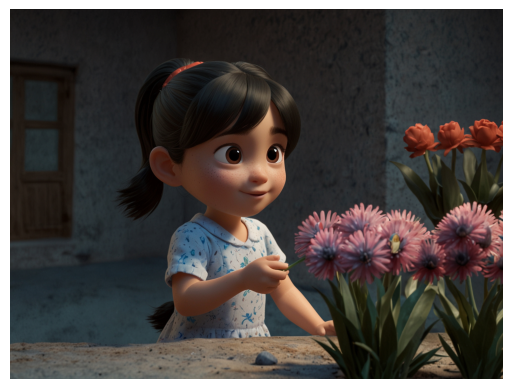

In [ ]:
dataset_id = "7ecca318-abc7-405b-903e-484bc492ad44"

print(dataset_id)

# Print the final number of images in the dataset
num_images = get_number_of_images_in_dataset(dataset_id)
print(f"Total images in dataset {dataset_id}: {num_images}")

# display all the images
display_all_images_in_dataset(dataset_id)

In [ ]:
"""
Function to get the the dataset.
"""
def train_user_model(user_model_name, dataset_id):

    url = "https://cloud.leonardo.ai/api/rest/v1/models"

    # Define the headers, make sure to include authorization if required
    headers = {
      "accept": "application/json",
      "content-type": "application/json",
      "authorization": authorization
    }

    payload = {
      "modelType": "CHARACTERS",
      "nsfw": False,
      "resolution": 512,
      "strength": "MEDIUM",
      "datasetId": dataset_id,
      "instance_prompt": "3D Disney Pixar-style animation character",
      "name": user_model_name
    }

    response = requests.post(url, json=payload, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        print(formatJson(response))
        response_data = response.json()
        sd_training_job = response_data.get('sdTrainingJob')
        if sd_training_job and sd_training_job.get('customModelId'):
            user_model_id = sd_training_job['customModelId']
            return user_model_id
    else:
        print(f"Failed to train the user model. Status code: {response.status_code}")
        return None

In [ ]:
user_model_id = train_user_model("test_user_model", dataset_id)

{
    "sdTrainingJob": {
        "customModelId": "a61edddb-2bde-4f44-9a91-2050db9433e2",
        "apiCreditCost": 750
    }
}


In [ ]:
# Pipeline

In [ ]:
# Step 1：根据prompt生成一张用户图像 （之后这一步变成生成多张，并让用户自己选择一张最喜欢的；并允许图生图）

In [ ]:
# Step 2：根据这张图像生成另外9张相似角色图，构成一个10张图的小dataset
# "When training a custom model with Leonardo AI, you can use a small set of images, typically between 8-20, to refine a model."

In [ ]:
# Step 3：用这个小dataset去train a custom model for user character

In [ ]:
# Step 4： 从识别到的日记文字生成出prompts，可以考虑用OpenAI的api来做（之后可能需要内容切割成多个prompts，现在初版可以先不管）

In [ ]:
# Step 5：用prompt和之前训练好的model来生成出日记图像

In [ ]:
# 可供参考的资料
# Leonardo API文档：https://docs.leonardo.ai/reference/